In [1]:
## Part 1 - Climate Graphs and Code

#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
#style.use('fivethirtyeight')


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from flask import Flask, jsonify
import json


# Reflect Tables into SQLAlchemy ORM

In [3]:
## Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, func, Column, Integer, String, Float, desc, inspect, or_, and_
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base


In [4]:
## Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

## Create our session (link) from Python to the DB
session = Session(bind=engine)

#Base = declarative_base()
#Base = automap_base()

In [5]:
## reflect an existing database into a new model
Base = automap_base()

## reflect the tables
Base.prepare(engine, reflect=True)

## View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
## Or could just use inspect method to get table names from sqlite after engine create
inspector = inspect(engine)
print(inspector.get_table_names())
print()

## Check table column values
MeasureCol = inspector.get_columns('measurement')
print("Measurement Table")
for col in MeasureCol:
    print(col["name"], col["type"])

print()

StationCol = inspector.get_columns('station')
print("Station Table")
for col in StationCol:
    print(col["name"], col["type"])

['measurement', 'station']

Measurement Table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
## Save references to each table
Measurement = Base.classes.measurement
Station  = Base.classes.station 

# Exploratory Precipitation Analysis

In [8]:
## Find the most recent date in the data set. 
MostRecentDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first() ## Using descending order, return 'first' Measurement date
MostRecentDate = MostRecentDate[0]  ## Convert date to just a string
MostRecentDate


'2017-08-23'

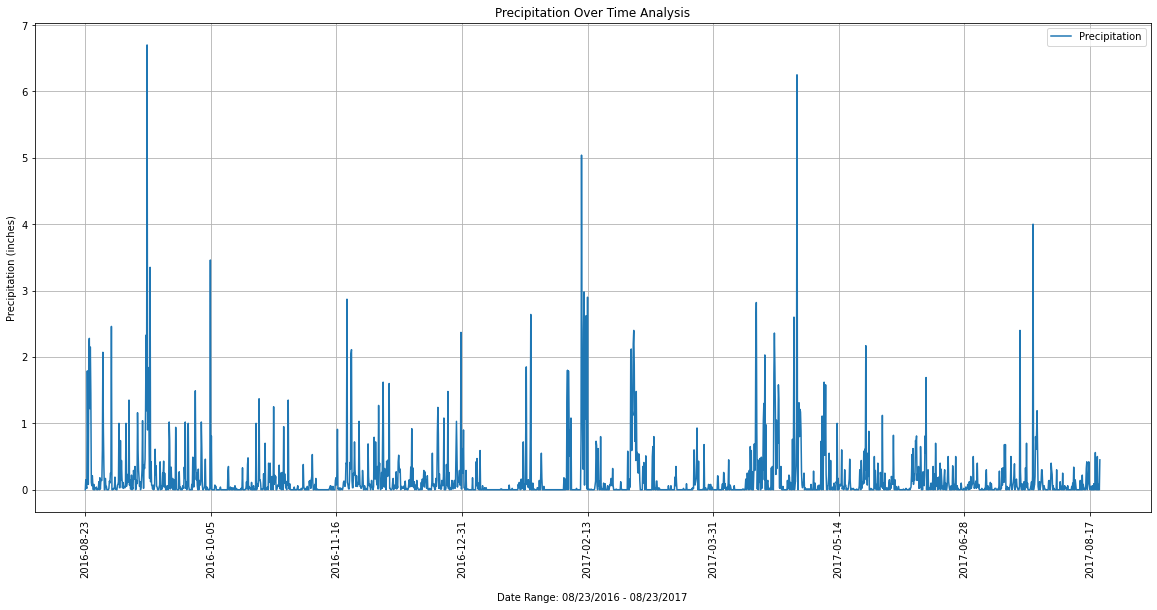

In [9]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results. Select only the `date` and `prcp` values.
## Starting from the most recent data point in the database. Note: do not pass in the date as a variable, will use 'MostRecentDate' instead

## Calculate the date one year from the last date in data set
## datetime.strptime() gives a datetime obj and timestamp and we subtract one year (365days), 
## dt.datetime.date() turns the "datetime.strptime" object into just the date (no timesttamp/datetime format), isoformat() changes output to string.
OneYearPriorDate = dt.datetime.strptime(MostRecentDate, '%Y-%m-%d') - dt.timedelta(365,0,0)
##print(OneYearPriorDate)
OneYearPriorDate = OneYearPriorDate.date()
##print(OneYearPriorDate)

#print(MostRecentDate)
#print(OneYearPriorDate)



## Perform a query to retrieve the data and precipitation scores
DatePrcpQuery = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= OneYearPriorDate).\
    filter(Measurement.date <= MostRecentDate).order_by(Measurement.date).all()
##print(DatePrcpQuery)



## Save the query results as a Pandas DataFrame and set the index to the date column
DatePrcp_DF = pd.DataFrame(DatePrcpQuery).rename(columns = {"date":"Date", "prcp":"Precipitation"}).set_index("Date")

## Dropping 'NAN'/None rows
DatePrcp_DF = DatePrcp_DF.dropna(how = 'any')
##DatePrcp_DF = DatePrcp_DF.fillna(value=0.00)

## Sort the dataframe by date
DatePrcp_DF = DatePrcp_DF.sort_values(by = 'Date')
DatePrcp_DF.head(20)



## Use Pandas Plotting with Matplotlib to plot the data
DatePrcp_DF.plot(title = "Precipitation Over Time Analysis", rot = 90, figsize = (20, 9))
plt.grid()
plt.legend(loc = 'upper right')
plt.xlabel("\n" "Date Range: 08/23/2016 - 08/23/2017")
plt.ylabel("Precipitation (inches)")
#plt.savefig("Resources/Precipitation.jpg", dpi=200)
plt.show()


In [10]:
## Use Pandas to calcualte the summary statistics for the precipitation data
DatePrcp_DF.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [11]:
## Reprint of table data for reference
## Measurement Table
## id INTEGER
## station TEXT
## date TEXT
## prcp FLOAT
## tobs FLOAT
## 
## Station Table
## id INTEGER
## station TEXT
## name TEXT
## latitude FLOAT
## longitude FLOAT
## elevation FLOAT

## Design a query to calculate the total number stations in the dataset
TotalStations = session.query(Station.id).count()
TotalStations

9

In [12]:
## Design a query to find the most active stations (i.e. what stations have the most rows?)
## List the stations and the counts in descending order.
## Hint: You will need to use a function such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries

MostActiveStations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
MostActiveStations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
## Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
## Hint: You will need to use a function such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries

## First station listed (index[0] = USC00519281', 2772) is the most active with 2772 rows, so will use this for filtering
TheMostActiveStation = MostActiveStations[0][0]
TheMostActiveStation   # = Station ID: 'USC00519281'

## tobs = temperature observation dataset
LowestTemp  = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == TheMostActiveStation).all()[0][0]
#LowestTemp

HighestTemp  = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == TheMostActiveStation).all()[0][0]
#HighestTemp

AvgTemp  = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == TheMostActiveStation).all()[0][0]
#AvgTemp

print(f"Here are the Temperatures recorded from station: {TheMostActiveStation}")
print(f"Lowest Temperature: {LowestTemp}, Highest Temperature: {HighestTemp}, Average Temperature: {AvgTemp}")


## OR can write all 3 calculations together in one variable/equation:
#AllTempCalc = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == TheMostActiveStation).all()
#AllTempCalc


Here are the Temperatures recorded from station: USC00519281
Lowest Temperature: 54.0, Highest Temperature: 85.0, Average Temperature: 71.66378066378067


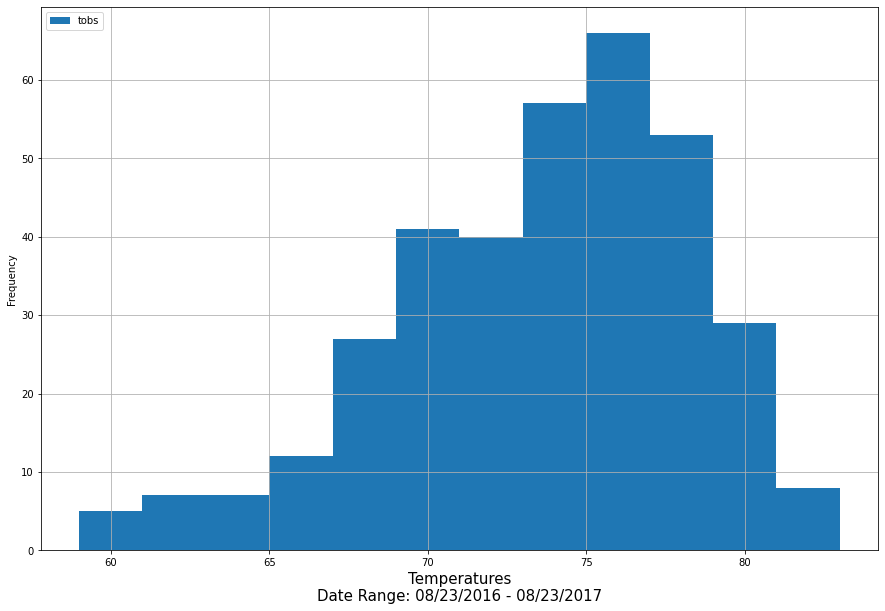

In [15]:
## Using the most active station id query the last 12 months of temperature observation data for this station.
## Plot the results as a histogram

## Perform a query to retrieve the data and precipitation scores
MostRecentActiveStationTobs = session.query(Measurement.tobs).\
    filter(Measurement.station == TheMostActiveStation).\
    filter(Measurement.date >= OneYearPriorDate).\
    filter(Measurement.date <= MostRecentDate).all()
#MostRecentActiveStationTobs

TempForStation_DF = pd.DataFrame(MostRecentActiveStationTobs, columns=['tobs'])
TempForStation_DF.plot.hist(bins = 12, figsize = (15, 10))
plt.grid()

plt.xlabel("Temperatures" "\n" "Date Range: 08/23/2016 - 08/23/2017", fontsize=15)
plt.ylabel("Frequency")
plt.legend(loc='upper left')
#plt.title("title")

#plt.savefig(f"Resources/Temp_Histogram.jpg", dpi=200)
plt.show()


# Close session

In [16]:
# Close Session
session.close()

In [ ]:
## ________________________________________ Ithamar Francois ______________________________________________________ ##